*   Name: Devin Augustin
*   NIM: 2440094352

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tqdm as tqdm

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,SimpleRNN,Embedding,Conv1D,Bidirectional,SpatialDropout1D,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix,classification_report

import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop=set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**1. Load the data**



In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df = pd.read_csv("/content/drive/MyDrive/Colab/UAS_DLO/mediumreview.csv")
df

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...
45409,d9964102-00a0-49ef-9286-b1c47581b7c5,very useful app,4,0,4.5.1155382,2022-12-20 15:53:24,NaN,NaN,USER_EXPERIENCE,POSITIVE
45410,014ea3e3-4d68-4917-a1f5-95a65c3839b7,try it. see why it rates 1.,1,0,NaN,2022-12-20 14:48:49,NaN,NaN,INTERFACE,NEUTRAL
45411,08fe9675-f425-490c-9bfe-c2e214015c0d,nice and easy very fast updates about news,5,0,4.5.1156292,2022-12-20 14:29:05,NaN,NaN,INTERFACE,POSITIVE
45412,ce773043-cd63-4cf1-af47-2ffc8b564619,this site is awesome .,4,0,4.5.1156292,2022-12-20 14:26:21,NaN,NaN,USER_EXPERIENCE,POSITIVE


#**2. Preprocessing and Preparing the Data**

Checking for any missing value.

Text(0.5, 0, 'Missing Values Count')

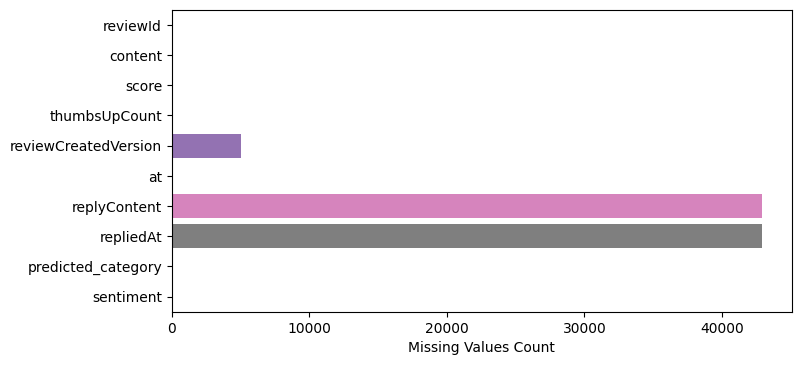

In [64]:
fig= plt.subplots(ncols=1, figsize=(8, 4), dpi=100)

sns_plot = sns.barplot(x=df.isnull().sum().values, y=df.isnull().sum().index)
sns_plot.set_xlabel('Missing Values Count')

reviewCreatedVersion, replyContent, and repliedAt have a lot of missing values here. 
<br>Now let's take a look at the sentiment data distribution.

Text(0.5, 1.0, 'Sentiment Data Distribution')

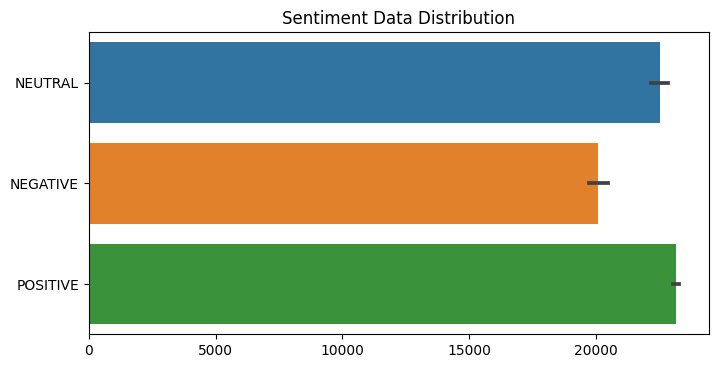

In [65]:
fig= plt.subplots(ncols=1, figsize=(8, 4), dpi=100)

sns_plot = sns.barplot(x=df['sentiment'].index, y=df['sentiment'].values)
sns_plot.set_title('Sentiment Data Distribution')

The dataset is good since there is no skewness in the distribution. Since we want to train only content to classify its sentiment, we gonna drop all the useless columns.

In [66]:
df2 = df.drop(['reviewId', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'predicted_category'], axis=1)
df2.head

<bound method NDFrame.head of                                                  content sentiment
0                                                   woww   NEUTRAL
1                    let me know more details about this   NEUTRAL
2      i've been using this for a while and there's a...  NEGATIVE
3                                                   good  POSITIVE
4                                                 mjkobe   NEUTRAL
...                                                  ...       ...
45409                                    very useful app  POSITIVE
45410                        try it. see why it rates 1.   NEUTRAL
45411         nice and easy very fast updates about news  POSITIVE
45412                             this site is awesome .  POSITIVE
45413                          cool newsletter timeline.  POSITIVE

[45414 rows x 2 columns]>

In [67]:
df2 = df2[df2.sentiment != 'NEUTRAL']

In [68]:
df2.sentiment.unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

#**Text Preprocessing**

Lower case all the texts.

In [70]:
df2['content'] = df2['content'].str.lower()

<ipython-input-70-1277dc17882c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].str.lower()


Remove the punctuation.

In [71]:
df2['content'] = df2['content'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

<ipython-input-71-1a5c54af65fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


Tokenize the words.

In [72]:
df2['content'] = df2['content'].apply(lambda x: word_tokenize(x))

<ipython-input-72-73908b00f7e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(lambda x: word_tokenize(x))


Remove stop words

In [73]:
stop_words = set(stopwords.words("english"))
df2['content'] = df2['content'].apply(lambda x: [word for word in x if word not in stop_words])

<ipython-input-73-7d78a57f0dac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(lambda x: [word for word in x if word not in stop_words])


Perform lemmatization

In [74]:
lemmatizer = WordNetLemmatizer()
df2['content'] = df2['content'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

<ipython-input-74-e9a8ecfc3183>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


Join tokenized words back into sentences

In [75]:
df2['content'] = df2['content'].apply(lambda x: ' '.join(x))

<ipython-input-75-d587c63940f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['content'] = df2['content'].apply(lambda x: ' '.join(x))


Convert labels to categorical values

In [76]:
sentiment = df2['sentiment'].astype('category').cat.codes
df2['sentiment'] = sentiment

<ipython-input-76-18b7c6c78c30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment'] = sentiment


In [77]:
df2.head(10)

,content,sentiment
2,ive using there basic bug still fixed scrollin...,0
3,good,1
5,good,1
6,awesome like read different topic great work d...,1
7,best thing discovered life thats call nature g...,1
8,good project,1
9,basic search functionality non existent result...,0
10,great project,1
11,wonderful app manager editorial staff idea beh...,1
12,medium magazine always provided timely informa...,1


We are going to use GloVe for vectorization.





In [78]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-02-06 17:42:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-06 17:42:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-06 17:42:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [79]:
glove_path = '/content/glove.6B.300d.txt'
embedding_dim = 300

In [80]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df2.content) 

In [81]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("\nVocabulary Size :", vocab_size)  



Vocabulary Size : 14203


In [82]:
embeddings_index = {}

### Processing the file
for line in open(glove_path):
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [83]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))  
for word, i in word_index.items():  ### unpacking the dictionary
    ### Checking whether the word exists in the pretrained embeddings_index
    embedding_vector = embeddings_index.get(word)  
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [84]:
embedding_layer = Embedding(vocab_size,embedding_dim,
                                        weights=[embedding_matrix],
                                          input_length=30, ### length of longest sentence
                                          trainable=False)

#**Train Test Split**

In [85]:
train_data, test_data = train_test_split(df2[["sentiment","content"]], test_size=0.2,
                                         random_state=23)

In [86]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.content),
                        maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.content),
                       maxlen = 30)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (31620, 30)
Testing X Shape: (7905, 30)


In [87]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (31620, 1)
y_test shape: (7905, 1)


#**The Bidirectional RNN model**

In [88]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,SimpleRNN,Embedding,Conv1D,Bidirectional,SpatialDropout1D,Dropout

from keras.optimizers import Adam

sequence_input = Input(shape=(30,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs) 

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])

In [89]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 30, 300)           4260900   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 300)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            96064     
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              16512     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 512)               6604

I chose this architecture for a few reasons:


1.   Simplicity: This architecture is simple and easy to understand, making it a good starting point for a beginner or someone who is just testing the waters of semantic segmentation.

2.   Flexibility: This architecture is flexible and can be modified or extended to include more layers or different types of layers depending on the specific problem and data.
3. Speed: This architecture is computationally efficient, which means it can be trained and evaluated quickly. This is especially important when dealing with large datasets or complex problems.
4. Effectiveness: This architecture can be effective in solving simple semantic segmentation problems, as long as the input data is linearly separable. If not, you may have to consider adding more complex layers like convolutional layers or recurrent layers.

Overall, the architecture is a good starting point for simple semantic segmentation problems, and can be used as a building block for more complex models.



#**Train the model**

In [90]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, epochs=20,validation_data=(x_test, y_test), batch_size = 1024,callbacks=[early_stopping])

Epoch 1/20
31/31 [==============================] - 16s 457ms/step - loss: 0.0000e+00 - accuracy: 0.1358 - val_loss: 0.0000e+00 - val_accuracy: 0.1370
Epoch 2/20
31/31 [==============================] - 14s 453ms/step - loss: 0.0000e+00 - accuracy: 0.1316 - val_loss: 0.0000e+00 - val_accuracy: 0.1370
Epoch 3/20
31/31 [==============================] - 14s 448ms/step - loss: 0.0000e+00 - accuracy: 0.1316 - val_loss: 0.0000e+00 - val_accuracy: 0.1370
Epoch 4/20
31/31 [==============================] - 14s 441ms/step - loss: 0.0000e+00 - accuracy: 0.1316 - val_loss: 0.0000e+00 - val_accuracy: 0.1370
Epoch 5/20
31/31 [==============================] - 14s 443ms/step - loss: 0.0000e+00 - accuracy: 0.1316 - val_loss: 0.0000e+00 - val_accuracy: 0.1370
Epoch 6/20
31/31 [==============================] - 14s 443ms/step - loss: 0.0000e+00 - accuracy: 0.1316 - val_loss: 0.0000e+00 - val_accuracy: 0.1370


#**Result**

In [91]:
pred = model.predict(x_test)
pred[:5]

248/248 [==============================] - 2s 9ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [92]:
pred = np.round(pred).astype(int)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [93]:
print(classification_report(y_test, pred, target_names = ['NEGATIVE','POSITIVE']))

              precision    recall  f1-score   support

    NEGATIVE       0.14      1.00      0.24      1083
    POSITIVE       0.00      0.00      0.00      6822

    accuracy                           0.14      7905
   macro avg       0.07      0.50      0.12      7905
weighted avg       0.02      0.14      0.03      7905



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
